In [1]:
import os
from pymatgen.core import Structure, Composition, Element
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.structure_matcher import StructureMatcher
import pandas as pd
from pyxtal import pyxtal
import numpy as np
import shutil
from tqdm import tqdm

# Load MP20 benchmark data

In [19]:
df_mp20_train = pd.read_csv('data/mp20_bench/train_v2.csv',index_col=0)
df_mp20_test = pd.read_csv('data/mp20_bench/test_v2.csv',index_col=0)
df_mp20_val = pd.read_csv('data/mp20_bench/val_v2.csv',index_col=0)

In [20]:
combined_train = pd.concat([df_mp20_train, df_mp20_val], axis=0)
combined_train['site_symmetry'] = [eval(i) for i in combined_train['site_symmetry']]
combined_train = combined_train.reset_index()
combined_train

,index,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,elements,cif,spacegroup.number,wyckoff_dic,n_element,site_symmetry
0,19480,mp-974729,-0.314759,0.0000,Nd(Al2Cu)4,0.000000,"['Al', 'Cu', 'Nd']",# generated using pymatgen\ndata_Nd(Al2Cu)4\n_...,139,"{'Nd': ['2a'], 'Al': ['8j', '8i'], 'Cu': ['8f']}",3,"((Al, m2m.), (Al, m2m.), (Cu, ..2/m), (Nd, 4/m..."
1,29624,mp-1185360,-0.193761,0.0000,LiMnIr2,0.018075,"['Ir', 'Li', 'Mn']",# generated using pymatgen\ndata_LiMnIr2\n_sym...,225,"{'Li': ['4b'], 'Mn': ['4a'], 'Ir': ['8c']}",3,"((Ir, -43m), (Li, m-3m), (Mn, m-3m))"
2,38633,mp-1188861,-0.584694,3.8556,LiCSN,0.048847,"['C', 'Li', 'N', 'S']",# generated using pymatgen\ndata_LiCSN\n_symme...,62,"{'Li': ['4c'], 'C': ['4c'], 'S': ['4c'], 'N': ...",4,"((C, .m.), (Li, .m.), (N, .m.), (S, .m.))"
3,10889,mp-677272,-2.474759,0.4707,La2EuS4,0.000000,"['Eu', 'La', 'S']",# generated using pymatgen\ndata_La2EuS4\n_sym...,122,"{'La': ['8d'], 'Eu': ['4a'], 'S': ['16e']}",3,"((Eu, -4..), (La, .2.), (S, 1))"
4,6575,mp-1104517,-0.641076,0.0000,Yb3Ga9Pt2,0.000000,"['Ga', 'Pt', 'Yb']",# generated using pymatgen\ndata_Yb3Ga9Pt2\n_s...,71,"{'Yb': ['2c', '4i'], 'Ga': ['8l', '8l', '2b'],...",3,"((Ga, m..), (Ga, m..), (Ga, mmm), (Pt, m2m), (..."
...,...,...,...,...,...,...,...,...,...,...,...,...
35225,25951,mp-770779,-2.441186,1.6807,VCrO3,0.009381,"['Cr', 'O', 'V']",# generated using pymatgen\ndata_VCrO3\n_symme...,1,"{'V': ['1a', '1a', '1a', '1a'], 'Cr': ['1a', '...",3,"((Cr, 1), (Cr, 1), (Cr, 1), (Cr, 1), (O, 1), (..."
35226,21009,mp-1023925,-1.152798,1.6970,WS2,0.001173,"['S', 'W']",# generated using pymatgen\ndata_WS2\n_symmetr...,164,"{'W': ['2d'], 'S': ['2d', '2d']}",2,"((S, 3m.), (S, 3m.), (W, 3m.))"
35227,31626,mp-1187764,-0.788772,0.0000,Y2ZnPt,0.022813,"['Pt', 'Y', 'Zn']",# generated using pymatgen\ndata_Y2ZnPt\n_symm...,225,"{'Y': ['8c'], 'Zn': ['4a'], 'Pt': ['4b']}",3,"((Pt, m-3m), (Y, -43m), (Zn, m-3m))"
35228,20673,mp-1219588,-2.910913,1.9239,RbMgCoF6,0.000710,"['Co', 'F', 'Mg', 'Rb']",# generated using pymatgen\ndata_RbMgCoF6\n_sy...,74,"{'Rb': ['4e'], 'Mg': ['4d'], 'Co': ['4a'], 'F'...",4,"((Co, 2/m..), (F, 1), (F, mm2), (F, mm2), (Mg,..."


In [21]:
df_mp20_test['site_symmetry'] = [eval(i) for i in df_mp20_test['site_symmetry']]
df_mp20_test = df_mp20_test.reset_index()
df_mp20_test

,index,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,elements,cif,spacegroup.number,wyckoff_dic,n_element,site_symmetry
0,6000,mp-10009,-0.575092,0.8980,GaTe,0.000000,"['Ga', 'Te']",# generated using pymatgen\ndata_GaTe\n_symmet...,194,"{'Ga': ['4f'], 'Te': ['4f']}",2,"((Ga, 3m.), (Te, 3m.))"
1,37702,mp-1218989,-0.942488,0.0000,SmThCN,0.044109,"['C', 'N', 'Sm', 'Th']",# generated using pymatgen\ndata_SmThCN\n_symm...,160,"{'Sm': ['3a'], 'Th': ['3a'], 'C': ['3a'], 'N':...",4,"((C, 3m), (N, 3m), (Sm, 3m), (Th, 3m))"
2,42245,mp-1225695,0.064863,0.0000,CuNi,0.064863,"['Cu', 'Ni']",# generated using pymatgen\ndata_CuNi\n_symmet...,65,"{'Cu': ['2c'], 'Ni': ['2a']}",2,"((Cu, mmm), (Ni, mmm))"
3,780,mp-1220884,-1.456116,0.0000,NaTiVS4,0.000000,"['Na', 'S', 'Ti', 'V']",# generated using pymatgen\ndata_NaTiVS4\n_sym...,8,"{'Na': ['2a'], 'Ti': ['2a'], 'V': ['2a'], 'S':...",4,"((Na, m), (S, m), (S, m), (S, m), (S, m), (Ti,..."
4,35749,mp-1224266,0.024139,0.0000,Ho3TmMn8,0.036496,"['Ho', 'Mn', 'Tm']",# generated using pymatgen\ndata_Ho3TmMn8\n_sy...,8,"{'Ho': ['2a', '2a', '2a'], 'Tm': ['2a'], 'Mn':...",3,"((Ho, m), (Ho, m), (Ho, m), (Mn, 1), (Mn, 1), ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
8833,7763,mp-21084,-1.777752,1.0134,In6Ga2PtO8,0.000000,"['Ga', 'In', 'O', 'Pt']",# generated using pymatgen\ndata_In6Ga2PtO8\n_...,225,"{'In': ['24e'], 'Ga': ['8c'], 'Pt': ['4a'], 'O...",4,"((Ga, -43m), (In, 4m.m), (O, .3m), (Pt, m-3m))"
8834,15377,mp-571486,-0.359373,0.0000,CuSe,0.000000,"['Cu', 'Se']",# generated using pymatgen\ndata_CuSe\n_symmet...,63,"{'Cu': ['8f', '4c'], 'Se': ['4c', '8f']}",2,"((Cu, m..), (Cu, m2m), (Se, m..), (Se, m2m))"
8835,17730,mp-14410,-1.205080,0.4594,Tl6TeO12,0.000000,"['O', 'Te', 'Tl']",# generated using pymatgen\ndata_Tl6TeO12\n_sy...,148,"{'Tl': ['18f'], 'Te': ['3a'], 'O': ['18f', '18...",3,"((O, 1), (O, 1), (Te, -3.), (Tl, 1))"
8836,28030,mp-1079192,-2.814520,0.0000,Sr2GdRuO6,0.014361,"['Gd', 'O', 'Ru', 'Sr']",# generated using pymatgen\ndata_Sr2GdRuO6\n_s...,87,"{'Sr': ['4d'], 'Gd': ['2a'], 'Ru': ['2b'], 'O'...",4,"((Gd, 4/m..), (O, 4..), (O, m..), (Ru, 4/m..),..."


# Pre-process CIF from WyCryst Generation

In [5]:
all_cif_dir = 'temp_files/validation_compound/WyCryst_mp20/all_minE_cif/'

In [6]:
df_result = pd.read_csv('temp_files/validation_compound/WyCryst_mp20/WyCryst_mp20_result.csv',index_col=0)
df_result.head(5)

,formula,file_dir,error_str,folder_ind,chgnet_ehull,corrected_chgnet_ehull
0,Pr4 Se4,temp_files/WyCryst_mp20/224/min_e_strc.cif,No valid decomposition found for PDEntry : Pr4...,224,0.000000,-0.001225
1,Mg1 Ti6,temp_files/WyCryst_mp20/460/min_e_strc.cif,no_error,460,0.372047,0.372047
2,Ta10 S16,temp_files/WyCryst_mp20/546/min_e_strc.cif,no_error,546,0.252635,0.252635
3,Bi6 F10,temp_files/WyCryst_mp20/945/min_e_strc.cif,no_error,945,0.424835,0.424835
4,Zn8 S4,temp_files/WyCryst_mp20/382/min_e_strc.cif,no_error,382,0.239109,0.239109


In [7]:
df_result.sort_values(by='folder_ind')

,formula,file_dir,error_str,folder_ind,chgnet_ehull,corrected_chgnet_ehull
38,Nd2 Al16 Cu8,temp_files/WyCryst_mp20/0/min_e_strc.cif,No valid decomposition found for PDEntry : Nd2...,0,0.000000,-0.003829
282,Li4 Mn4 Ir8,temp_files/WyCryst_mp20/1/min_e_strc.cif,No valid decomposition found for PDEntry : Li4...,1,0.000000,-0.000484
849,Na8 Bi8 O12,temp_files/WyCryst_mp20/2/min_e_strc.cif,no_error,2,0.247835,0.247835
837,In4 Bi4 S6,temp_files/WyCryst_mp20/3/min_e_strc.cif,no_error,3,0.072925,0.072925
327,Ti4 Cu16,temp_files/WyCryst_mp20/4/min_e_strc.cif,no_error,4,0.032536,0.032536
...,...,...,...,...,...,...
40,Li27 Cr18 O24,temp_files/WyCryst_mp20/995/min_e_strc.cif,no_error,995,1.036843,1.036843
732,Nb6 Co8 B4,temp_files/WyCryst_mp20/996/min_e_strc.cif,no_error,996,0.083476,0.083476
601,K8 Pt2 S8,temp_files/WyCryst_mp20/997/min_e_strc.cif,no_error,997,0.258884,0.258884
550,Ti1 Al1 Au2,temp_files/WyCryst_mp20/998/min_e_strc.cif,no_error,998,0.009467,0.009467


In [8]:
df_all_gene = pd.read_csv('temp_files/validation_compound/WyCryst_mp20/WyCryst_MP20_Genes.csv',index_col=0)
df_all_gene

,n_element,reconstructed_formula,reconstructed_ratio,reconstructed_ratio1,reconstructed_wyckoff,reconstructed_sg,predicted_property,reconstructed_DoF,str_wyckoff,ter_sys,n_sites,oxid_test
0,3,Nd2Al16Cu8,2168,"[2.0, 16.0, 8.0]","{'Nd': ['2a'], 'Al': ['8i', '8j'], 'Cu': ['8f']}",139,NaN,2.0,"{'Nd': ['2a'], 'Al': ['8i', '8j'], 'Cu': ['8f']}","['Nd', 'Al', 'Cu']",26.0,NaN
1,3,Li4Mn4Ir8,448,"[4.0, 4.0, 8.0]","{'Li': ['4b'], 'Mn': ['4a'], 'Ir': ['8c']}",225,NaN,0.0,"{'Li': ['4b'], 'Mn': ['4a'], 'Ir': ['8c']}","['Li', 'Mn', 'Ir']",16.0,False
4,3,Na8Bi8O12,8812,"[8.0, 8.0, 12.0]","{'Na': ['2a', '2d', '4h'], 'Bi': ['4g', '4i'],...",12,NaN,9.0,"{'Na': ['2a', '2d', '4h'], 'Bi': ['4g', '4i'],...","['Na', 'Bi', 'O']",28.0,NaN
5,3,In4Bi4S6,446,"[4.0, 4.0, 6.0]","{'In': ['2a', '2e'], 'Bi': ['2e', '2e'], 'S': ...",11,NaN,12.0,"{'In': ['2a', '2e'], 'Bi': ['2e', '2e'], 'S': ...","['In', 'Bi', 'S']",14.0,True
7,2,Ti4Cu16,416,"[4.0, 16.0]","{'Ti': ['4c'], 'Cu': ['4c', '4c', '4c', '4c']}",62,NaN,10.0,"{'Ti': ['4c'], 'Cu': ['4c', '4c', '4c', '4c']}","['Ti', 'Cu']",20.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
142277,3,Ga3Ge1Pt7,317,"[3.0, 1.0, 7.0]","{'Ga': ['1a', '1b', '1b'], 'Ge': ['1a'], 'Pt':...",6,NaN,22.0,"{'Ga': ['1a', '1b', '1b'], 'Ge': ['1a'], 'Pt':...","['Ga', 'Ge', 'Pt']",11.0,False
142278,3,Mn6O5F7,657,"[6.0, 5.0, 7.0]","{'Mn': ['1a', '1a', '1a', '1a', '1a', '1a'], '...",1,NaN,54.0,"{'Mn': ['1a', '1a', '1a', '1a', '1a', '1a'], '...","['Mn', 'O', 'F']",18.0,True
142280,3,Ca8Fe4H24,8424,"[8.0, 4.0, 24.0]","{'Ca': ['8c'], 'Fe': ['4a'], 'H': ['24e']}",225,NaN,1.0,"{'Ca': ['8c'], 'Fe': ['4a'], 'H': ['24e']}","['Ca', 'Fe', 'H']",36.0,NaN
142281,3,V4Cr4O12,4412,"[4.0, 4.0, 12.0]","{'V': ['1a', '1a', '1a', '1a'], 'Cr': ['1a', '...",1,NaN,60.0,"{'V': ['1a', '1a', '1a', '1a'], 'Cr': ['1a', '...","['V', 'Cr', 'O']",20.0,True


In [9]:
# # transfer cif from original WyCryst generation dir to all_cif_dir, only need to run once
# for folder_ind in df_result['folder_ind']:
#     print()
#     cif_dir = f'temp_files/validation_compound/WyCryst_mp20/{folder_ind}/'
#     shutil.copyfile(cif_dir+'min_e_strc.cif',all_cif_dir+f'{folder_ind}_min_e_strc.cif')

# Load all generated CIF

### Taking WyCryst as example, now all cif is store in one folder

In [10]:
cif_lst = os.listdir(all_cif_dir)
cif_lst[:5]

['0_min_e_strc.cif',
 '100_min_e_strc.cif',
 '101_min_e_strc.cif',
 '102_min_e_strc.cif',
 '103_min_e_strc.cif']

In [11]:
all_gen_cif = [Structure.from_file(all_cif_dir+i) for i in cif_lst]
print(len(all_gen_cif))

c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\pymatgen\io\cif.py:1186: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(
c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\pymatgen\io\cif.py:1219: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\pymatgen\io\cif.py:1219: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
c:\users\raymo\

997


### Compute novelty score for all CIF

In [12]:
def get_structure_info(
    structure:Structure,
    tol: float = 0.1):
    pyxtal_structure = pyxtal()
    pyxtal_structure.from_seed(structure, tol=tol)

    elements = [Element(site.specie) for site in pyxtal_structure.atom_sites]
    # electronegativity = [element.X for element in elements]
    wyckoffs = [site.wp for site in pyxtal_structure.atom_sites]
    for wp in wyckoffs:
        wp.get_site_symmetry()
    site_symmetries = [wp.site_symm for wp in wyckoffs]
    multiplicity = [wp.multiplicity for wp in wyckoffs]
    dof = [wp.get_dof() for wp in wyckoffs]

    return elements,wyckoffs,site_symmetries,multiplicity,dof

In [31]:
# A set to store unique (formula, space group, Wyckoff site) combinations in the training set
training_dict= {}
training_wyckoff_sites = combined_train['site_symmetry'].to_list()

# Populate the training_combinations set
for i in tqdm(range(combined_train.shape[0])):
    #get symmetrized structure
    structure = Structure.from_str(combined_train['cif'].to_list()[i],fmt='cif')
    # spa = SpacegroupAnalyzer(structure)
    # symmetrized_structure = spa.get_symmetrized_structure()
    # symmetrized_structure = spa.get_conventional_standard_structure()
    
    formula = structure.composition.reduced_formula
    space_group = structure.get_space_group_info()[1]  # Gets the space group number, default tolerance are applied here

    # use pyxtal to get site symmetry, the wyckoff site identifier can be either Wyckoff symbol, or site symmetry
    # elements,wyckoffs,site_symmetries,multiplicity,dof=get_structure_info(structure)

    # two ways to obtain site symmetry, one is using pymatgen for wyckoff symbol, other is using pyxtal to get site symmetry
    # wyckoff_sites = tuple(sorted((site.species_string,symbol) for site,symbol in list(zip(symmetrized_structure.sites
    #                              ,symmetrized_structure.wyckoff_symbols))))
    # wyckoff_sites = tuple(sorted((str(element),symbol) for element,symbol in list(zip(elements
    #                          ,site_symmetries))))

    #load wyckoff sites using saved pxtal site symmetry
    wyckoff_sites = training_wyckoff_sites[i]
    
    identifier = (formula, space_group, wyckoff_sites)
    
    # Add the structure to the dictionary under the identifier key
    if identifier in training_dict:
        training_dict[identifier].append(structure)
    else:
        training_dict[identifier] = [structure]

 12%|████████████████████████████████▊                                                                                                                                                                                                                                           | 4318/35230 [00:34<04:33, 113.19it/s]c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\pymatgen\io\cif.py:1219: UserWarning: Issues encountered while parsing CIF: 30 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
 14%|████████████████████████████████████▉                                                                                                                                                                                                                                       | 4854/35230 [00:39<03:50, 131.70it/s]c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\pyma

In [42]:
# A set to store unique (formula, space group, Wyckoff site) combinations in the training set
test_dict= {}
test_wyckoff_sites = df_mp20_test['site_symmetry'].to_list()

# Populate the training_combinations set
for i in tqdm(range(df_mp20_test.shape[0])):
    #get symmetrized structure
    structure = Structure.from_str(df_mp20_test['cif'][i],fmt='cif')
    # spa = SpacegroupAnalyzer(structure)
    # symmetrized_structure = spa.get_symmetrized_structure()
    # symmetrized_structure = spa.get_conventional_standard_structure()
    
    formula = structure.composition.reduced_formula
    space_group = structure.get_space_group_info()[1]  # Gets the space group number, default tolerance are applied here

    # use pyxtal to get site symmetry, the wyckoff site identifier can be either Wyckoff symbol, or site symmetry
    # elements,wyckoffs,site_symmetries,multiplicity,dof=get_structure_info(structure)

    # two ways to obtain site symmetry, one is using pymatgen for wyckoff symbol, other is using pyxtal to get site symmetry
    # wyckoff_sites = tuple(sorted((site.species_string,symbol) for site,symbol in list(zip(symmetrized_structure.sites
    #                              ,symmetrized_structure.wyckoff_symbols))))
    # wyckoff_sites = tuple(sorted((str(element),symbol) for element,symbol in list(zip(elements
    #                          ,site_symmetries))))

    #load wyckoff sites using saved pxtal site symmetry
    wyckoff_sites = test_wyckoff_sites[i]
    
    identifier = (formula, space_group, wyckoff_sites)
    
    # Add the structure to the dictionary under the identifier key
    if identifier in test_dict:
        test_dict[identifier].append(structure)
    else:
        test_dict[identifier] = [structure]

  0%|                                                                                                                                                                                                                                                                                         | 0/8838 [00:00<?, ?it/s]c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\pymatgen\io\cif.py:1186: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(
c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\pymatgen\io\cif.py:1219: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
c:\users\raymo\

In [34]:
# # A set to store unique (formula, space group, Wyckoff site) combinations in the training set
# val_dict= {}
# all_wyckoff_sites = []

# # Populate the training_combinations set
# for i in tqdm(range(df_mp20_val.shape[0])):
# # for i in tqdm(range(3)):
#     #get symmetrized structure
#     structure = Structure.from_str(df_mp20_val['cif'].to_list()[i],fmt='cif')
#     # spa = SpacegroupAnalyzer(structure)
#     # symmetrized_structure = spa.get_symmetrized_structure()
#     # symmetrized_structure = spa.get_conventional_standard_structure()
    
#     formula = structure.composition.reduced_formula
#     space_group = structure.get_space_group_info()[1]  # Gets the space group number, default tolerance are applied here

#     # use pyxtal to get site symmetry, the wyckoff site identifier can be either Wyckoff symbol, or site symmetry
#     elements,wyckoffs,site_symmetries,multiplicity,dof=get_structure_info(structure)
    
#     # wyckoff_sites = tuple(sorted((site.species_string,symbol) for site,symbol in list(zip(symmetrized_structure.sites
#     #                              ,symmetrized_structure.wyckoff_symbols))))
#     wyckoff_sites = tuple(sorted((str(element),symbol) for element,symbol in list(zip(elements
#                              ,site_symmetries))))
#     all_wyckoff_sites.append(wyckoff_sites)
    
#     identifier = (formula, space_group, wyckoff_sites)
    
#     # Add the structure to the dictionary under the identifier key
#     if identifier in val_dict:
#         val_dict[identifier].append(structure)
#     else:
#         val_dict[identifier] = [structure]

In [35]:
# df_mp20_val['site_symmetry'] = all_wyckoff_sites

In [43]:
test_dict

{('GaTe',
  194,
  (('Ga', '3m.'), ('Te', '3m.'))): [Structure Summary
  Lattice
      abc : 4.13459945 4.13459945 18.42557
   angles : 90.0 90.0 119.99999121
   volume : 272.78374470718353
        A : 4.13459945 0.0 2.531711991099453e-16
        B : -2.0672991756737704 3.5806684753267577 2.531711991099453e-16
        C : 0.0 0.0 18.42557
      pbc : True True True
  PeriodicSite: Ga0 (Ga) (3.662e-07, 2.387, 3.371) [0.3333, 0.6667, 0.183]
  PeriodicSite: Ga1 (Ga) (2.067, 1.194, 12.58) [0.6667, 0.3333, 0.683]
  PeriodicSite: Ga2 (Ga) (2.067, 1.194, 15.05) [0.6667, 0.3333, 0.817]
  PeriodicSite: Ga3 (Ga) (3.662e-07, 2.387, 5.842) [0.3333, 0.6667, 0.317]
  PeriodicSite: Te4 (Te) (3.662e-07, 2.387, 16.33) [0.3333, 0.6667, 0.8862]
  PeriodicSite: Te5 (Te) (2.067, 1.194, 7.116) [0.6667, 0.3333, 0.3862]
  PeriodicSite: Te6 (Te) (2.067, 1.194, 2.097) [0.6667, 0.3333, 0.1138]
  PeriodicSite: Te7 (Te) (3.662e-07, 2.387, 11.31) [0.3333, 0.6667, 0.6138]],
 ('SmThCN',
  160,
  (('C', '3m'),
   ('N'

In [44]:
len(training_dict.keys()),len(test_dict.keys())

(34615, 8775)

In [47]:
# Initialize StructureMatcher
matcher = StructureMatcher()
novel_count = 0
novel_identifiers = []
novel_structures = []

# Check for novel structures in the "all_gen_cif"
for structure in all_gen_cif[:]:
    #get symmetrized structure
    
    formula = structure.composition.reduced_formula
    space_group = structure.get_space_group_info()[1]  # Gets the space group number

    # use pyxtal to get site symmetry, the wyckoff site identifier can be either Wyckoff symbol, or site symmetry
    elements,wyckoffs,site_symmetries,multiplicity,dof=get_structure_info(structure)
#     # wyckoff_sites = tuple(sorted((site.species_string,symbol) for site,symbol in list(zip(symmetrized_structure.sites
#     #                              ,symmetrized_structure.wyckoff_symbols))))
    wyckoff_sites = tuple(sorted((str(element),symbol) for element,symbol in list(zip(elements
                             ,site_symmetries))))
    
    
    identifier = (formula, space_group, wyckoff_sites)
    
    # If the identifier is not in the training set, it's novel
    if identifier not in training_dict:
        novel_identifiers.append(identifier)
        novel_structures.append(structure)
        novel_count += 1
    else:
        # Retrieve the list of matching structures from the dictionary
        matching_training_structures = training_dict[identifier]
        # Perform StructureMatcher comparison only with matching structures
        for train_structure in matching_training_structures:
            if matcher.fit(structure, train_structure):
                break
        else:
            # No exact match found, so the structure is novel
            novel_identifiers.append(identifier)
            novel_structures.append(structure)
            novel_count += 1

print(f"Number of generated structures: {len(all_gen_cif)}")
print(f"Number of novel structures: {novel_count}")


c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\spglib\spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['hall_number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\spglib\spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\spglib\spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
c:\users\raymo\desktop\wyckoff_post\venv3.9\lib\site-packages\spglib\spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
c:\users\ray

Number of generated structures: 997
Number of novel structures: 528


In [48]:
len(novel_identifiers),len(novel_structures)

(528, 528)

# get first 1000 novel cif

In [49]:
n_samples = 100
novel_set = [(novel_identifiers[i],novel_structures[i]) for i in range(n_samples)]

# Stats

In [50]:
from scipy.stats import wasserstein_distance, kstest
from matplotlib import pyplot as plt

#### Number of Sites

In [51]:
generated_no_sites = [len(identifier[2]) for identifier, structure in novel_set]
test_no_sites = [len(identifier[2]) for identifier in test_dict.keys()]

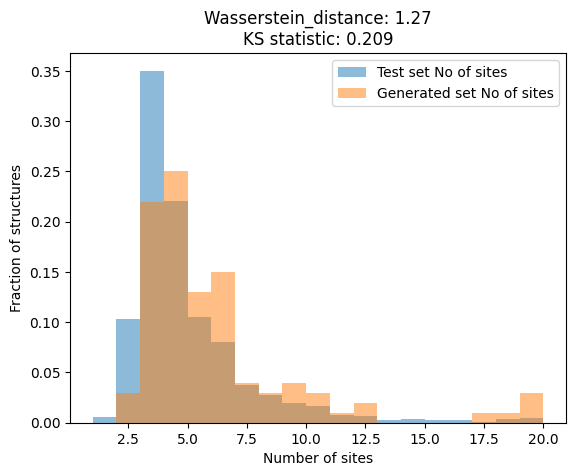

In [52]:
fig, ax = plt.subplots()
bins = np.arange(1, 21)
ax.hist(test_no_sites, bins=bins, alpha=0.5, label='Test set No of sites', density=True)
ax.hist(generated_no_sites, bins=bins, alpha=0.5, label='Generated set No of sites', density=True)
ax.set_xlabel('Number of sites')
ax.set_ylabel('Fraction of structures')
ax.set_title(f"Wasserstein_distance: {wasserstein_distance(test_no_sites, generated_no_sites):.2f}\n"
 f"KS statistic: {kstest(test_no_sites, generated_no_sites).statistic:.3f}")
ax.legend();

#### Number of Elements

In [53]:
generated_no_elements = [len(Composition(identifier[0]).elements) for identifier, structure in novel_set]
test_no_elements = [len(Composition(identifier[0]).elements) for identifier in test_dict.keys()]

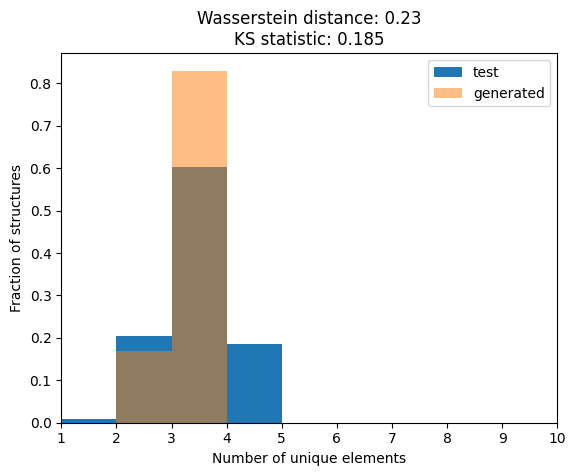

In [54]:
fig, ax = plt.subplots()
bins = range(1, 10)
ax.hist(test_no_elements, label="test", density=True, bins=bins)
ax.hist(generated_no_elements, label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Fraction of structures")
ax.legend()
ax.set_title(f"Wasserstein distance: {wasserstein_distance(test_no_elements, generated_no_elements):.2f}\n"
    f"KS statistic: {kstest(test_no_elements, generated_no_elements).statistic:.3f}")
ax.set_xlim((1,10));

#### Site Symmetry

In [56]:
from collections import Counter
from itertools import chain

In [99]:
test_ss_frequency = Counter([symmetry[1] for symmetry in chain(*df_mp20_test['site_symmetry'])])
generated_ss = chain(*(t[2] for t in novel_identifiers))
generated_ss_frequency = Counter([symmetry[1] for symmetry in generated_ss])

In [111]:
sorted_ss, test_count = map(list, zip(*sorted(test_ss_frequency.items(), key=lambda x: x[1], reverse=True)))
test_count = np.array(test_count)
generated_count = [generated_ss_frequency[ss] for ss in sorted_ss]
generated_count = np.array(generated_count)

In [112]:
exclusion_mask = ~((test_count == 0) | (generated_count == 0))


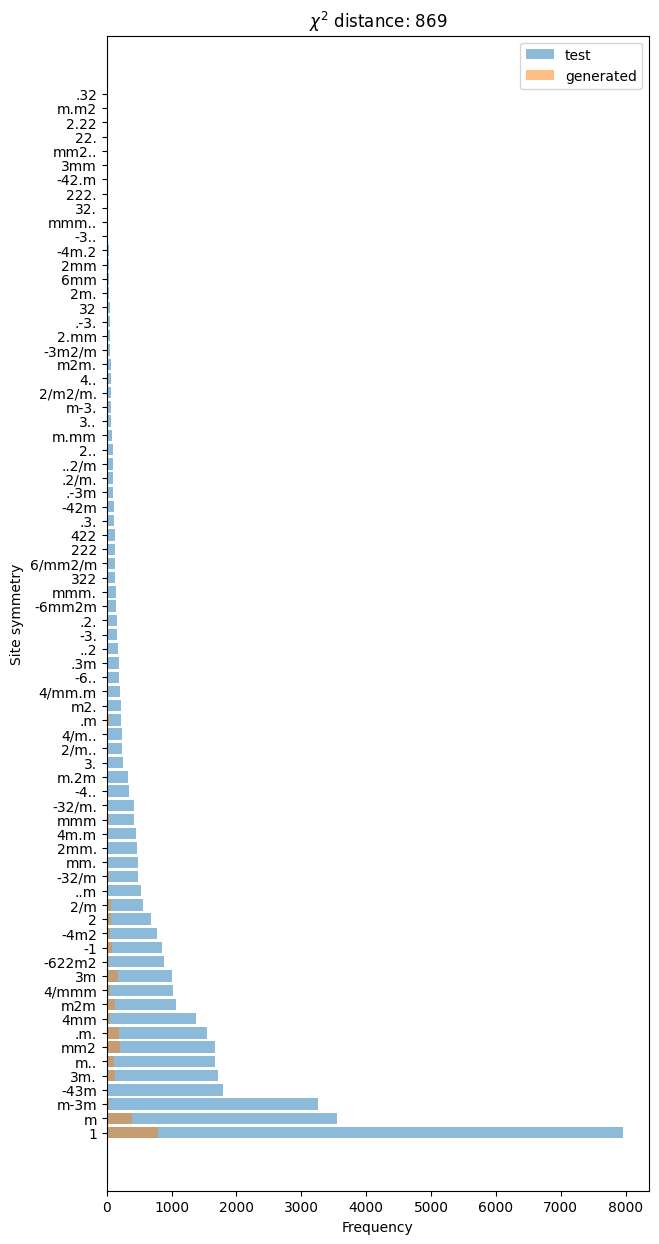

In [114]:
from scipy.stats import chi2_contingency
chi2_results = chi2_contingency(np.vstack([test_count[exclusion_mask], generated_count[exclusion_mask]]))
fig, ax = plt.subplots(figsize=(7, 15))
ax.barh(range(len(sorted_ss)), test_count, alpha=0.5, label='test')
ax.barh(range(len(sorted_ss)), generated_count, alpha=0.5, label='generated')
ax.set_xlabel('Frequency')
ax.set_ylabel('Site symmetry');
ax.set_title(f"$\\chi^2$ distance: {chi2_results[0]:.0f}")
high_bins = test_count > 0.001
ax.set_yticks(np.nonzero(high_bins)[0])
ax.set_yticklabels([sorted_ss[i] for i in np.nonzero(high_bins)[0]])
ax.legend();

# Validity Metrics

#### Smact validity

In [121]:
import smact
from smact.screening import pauling_test
from smact import Element as smt_element

In [130]:
def neutral_test(string: str):
    compos = Composition(string)
    override_dic = {}
    elements_list = compos.elements
    elements_sorted = sorted(elements_list, key=lambda obj: obj.X)
    for count, item in enumerate(elements_sorted):
        override_lst = smt_element(item.value).oxidation_states
        if count == 0:
            override_dic[item.value] = [i for i in override_lst if i>0]
#         elif count == (len(compos.elements)-1):
#             override_dic[item.value] = [i for i in override_lst if i<0]
        else:
            if item.value == "Te":
                override_dic[item.value] = override_lst
            elif Element(item.value).is_metal or Element(item.value).is_metalloid:
                override_dic[item.value] = [i for i in override_lst if i>0]
            else:
                override_dic[item.value] = override_lst

#     element_max_X = max(elements_list, key=lambda obj: obj.X)
#     element_min_X = min(elements_list, key=lambda obj: obj.X)
#     element_med_X = elements_list
#     element_med_X.remove(element_max_X)
#     element_med_X.remove(element_min_X)
    
    
#     print(f"Oxidation states used for test: {override_dic}")

    oxidation_states = compos._get_oxi_state_guesses(target_charge=0,
                                                      all_oxi_states=True,
                                                      max_sites=-1,
                                                      oxi_states_override=override_dic)
#     print(f"The guessed oxidation states for {string}: {oxidation_states}")
    if all(len(item) == 0 for item in oxidation_states):
#         print(f"{string} is NOT charge neutral.")
        return False
    else:
        # print(f"{string} IS charge neutral with guessed oxidation states: {oxidation_states}")
        return True

In [131]:
try:
    neutral_test('Mn4S4')
except:
    pass

In [150]:
gen_smact_result = []
for i in tqdm(range(n_samples)):
    compos = novel_set[i][0][0]
    gen_smact_result.append(neutral_test(compos))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.46it/s]


In [151]:
print(f"{np.sum(smact_test_result)} out of {n_samples} are charge neutral, the score is {np.round(np.sum(gen_smact_result)/n_samples*100,decimals=4)}%")

57 out of 100 are charge neutral, the score is 57.0%


#### Structure_validity

In [152]:
def structure_validity(crystal, cutoff=0.5):
    dist_mat = crystal.distance_matrix
    # Pad diagonal with a large number
    dist_mat = dist_mat + np.diag(
        np.ones(dist_mat.shape[0]) * (cutoff + 10.))
    if dist_mat.min() < cutoff or crystal.volume < 0.1:
        return False
    else:
        return True

In [153]:
gen_validity_result = []
for i in tqdm(range(n_samples)):
    struc = novel_set[i][1]
    gen_validity_result.append(structure_validity(struc))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2815.16it/s]


In [155]:
print(f"{np.sum(gen_validity_result)} out of {n_samples} are structral valid, the score is {np.round(np.sum(gen_validity_result)/n_samples*100,decimals=4)}%")

100 out of 100 are structral valid, the score is 100.0%


# Relax 1000 cif

## at the end this will be .py for people run

## aviod errors, at the end will end up with ~990 relaxed structure

# ehull evaluation